In [1]:
import numpy as np
import pandas as pd
import jieba as jb
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras.optimizers import RMSprop
import keras.backend as K

/home/wave/software/anaconda/envs/atec/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
jb.load_userdict('./dict.txt')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.449 seconds.
Prefix dict has been built succesfully.


In [3]:
# define constant
MAX_LEN = 60
EMD_DIM = 200

with open('stopwords_simple.txt') as f:
    STOP_WORDS = f.read().decode('utf-8').split()

In [4]:
# read data
data1 = pd.read_csv('atec_nlp_sim_train.csv', sep='\t', index_col=0, names=['sen1', 'sen2', 'label'])
data2 = pd.read_csv('atec_nlp_sim_train_add.csv', sep='\t', index_col=0, names=['sen1', 'sen2', 'label'])
data = pd.concat([data1, data2])

sens1, sens2, labels = data['sen1'].as_matrix(), data['sen2'].as_matrix(), data['label'].as_matrix()

In [5]:
def train_test_split(X1, X2, y, test_size=0.2, shuffle=True):
    leng = len(y)
    inds = np.arange(leng)
    if shuffle:
        np.random.shuffle(inds)
    hook = int(leng * test_size)
    X1_train, X2_train, y_train = X1[inds[:-hook]], X2[inds[:-hook]], y[inds[:-hook]]
    X1_test, X2_test, y_test = X1[inds[-hook:]], X2[inds[-hook:]], y[inds[-hook:]]
    return X1_train, X2_train, y_train, X1_test, X2_test, y_test

In [6]:
class MyTokenizer():
    def __init__(self, stopwords=[]):
        self.stopwords = stopwords
        self.word_dict = {'<PAD>':0, '<UNK>':1}
        
    def fit(self, texts):
        for seq in texts:
            words = jb.lcut(seq)
            words = [w for w in words if w.strip() and w not in self.stopwords]
            for w in words:
                if w not in self.word_dict:
                    self.word_dict[w] = len(self.word_dict)
        return self.word_dict
    
    def texts_to_seqs(self, texts):
        result = []
        for seq in texts:
            words = jb.lcut(seq)
            words = [w for w in words if w.strip() and w not in self.stopwords]
            result.append([self.word_dict[w] if w in self.word_dict else 1 for w in words])
        return result

In [7]:
def fscore(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    tp = K.sum(K.cast(K.equal(y_true+y_pred, 2.), dtype='float32'))
    pred_p = K.sum(y_pred) + K.epsilon()
    actual_p = K.sum(y_true) + K.epsilon()
    precision = tp / pred_p
    recall = tp / actual_p
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [8]:
def weighted_binary_crossentropy(y_true, y_pred):
    p = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    loss = -(1.3 * y_true * K.log(p) + 0.7 * (1. - y_true) * K.log(1. - p))
    return K.mean(loss)

In [9]:
def my_model(vocab_size, lr=0.001, loss='binary_crossentropy'):
    
    input1 = Input(shape=(MAX_LEN,))
    input2 = Input(shape=(MAX_LEN,))
    
    embedding = Embedding(vocab_size, EMD_DIM, input_length=MAX_LEN)    
    conv1d = Conv1D(128, 3, padding='same')
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))
    lstm2 = Bidirectional(LSTM(128, return_sequences=True))
    pooling1d = MaxPooling1D(pool_size=2, padding='same')
    
    x1 = embedding(input1)
    x2 = embedding(input2)
    
    x1 = conv1d(x1)
    #x1 = BatchNormalization()(x1)
    x2 = conv1d(x2)
    #x2 = BatchNormalization()(x2)
    
    x1 = pooling1d(x1)
    x2 = pooling1d(x2)
    
    x1 = lstm1(x1)
    #x1 = BatchNormalization()(x1)
    x2 = lstm1(x2)
    #x2 = BatchNormalization()(x2)
    
    x1 = lstm2(x1)
    #x1 = BatchNormalization()(x1)
    x2 = lstm2(x2)
    #x2 = BatchNormalization()(x2)
    
    x3 = Multiply()([x1, x2])    
    
    x4 = Subtract()([x1, x2])
    x4 = Lambda(lambda x: K.abs(x))(x4)
    
    x = Concatenate(axis=-1)([x3, x4])
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100)(x)
    
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[input1, input2], outputs=pred)
    
    model.compile(optimizer=RMSprop(lr=lr),
                  loss=loss,
                  metrics=['accuracy', fscore])
    
    return model

In [10]:
#split data
X1_train, X2_train, y_train, X1_test, X2_test, y_test = train_test_split(sens1, sens2, labels, test_size=0.1)

In [11]:
tokenizer = MyTokenizer(STOP_WORDS)
vocab = tokenizer.fit(np.concatenate((X1_train, X2_train), axis=0))

In [12]:
to_paded_seqs = lambda x:pad_sequences(tokenizer.texts_to_seqs(x),\
                    maxlen=MAX_LEN, padding='post', truncating='post')

X1_train, X2_train = to_paded_seqs(X1_train), to_paded_seqs(X2_train)
X1_test, X2_test = to_paded_seqs(X1_test), to_paded_seqs(X2_test)

In [14]:
model = my_model(len(vocab), lr=0.001, loss=weighted_binary_crossentropy)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 200)      2509800     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 128)      76928       embedding_1[0][0]                
          

In [ ]:
hist = model.fit([X1_train, X2_train], y_train, batch_size=128, epochs=20, validation_data=([X1_test, X2_test], y_test))

Train on 92230 samples, validate on 10247 samples
Epoch 1/20
 4096/92230 [>.............................] - ETA: 25:51 - loss: 3.3631 - acc: 0.8198 - fscore: 0.0056

In [52]:
print(1 - y_train.sum()*1.0 / len(y_train))
print(1 - y_test.sum()*1.0 / len(y_test))
model.save('./my_model.h5')

0.8180960641873577
0.8137991607299697


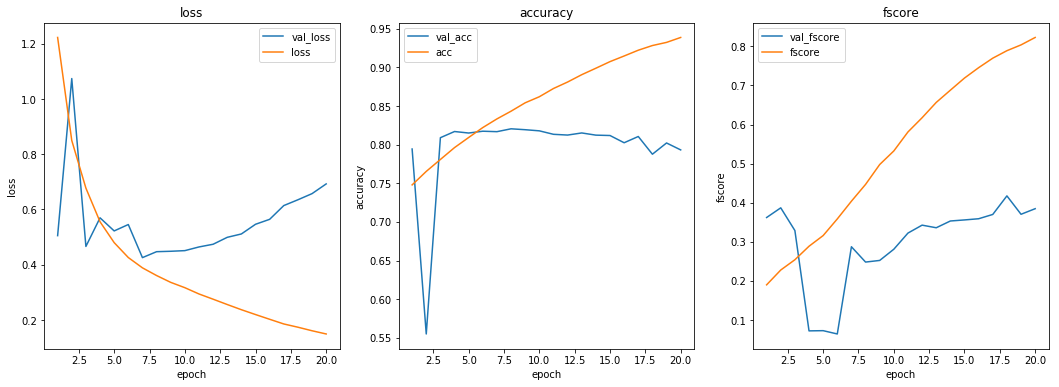

In [53]:
from matplotlib import pyplot as plt

his = hist.history
epochs = list(range(1, 21))
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.title('fscore')
plt.plot(epochs, his['val_fscore'], label='val_fscore')
plt.plot(epochs, his['fscore'], label='fscore')
plt.xlabel('epoch')
plt.ylabel('fscore')
plt.legend()

plt.show()

#### 以下代码只是辅助找出数据里的一些常用词以补充jieba词典

In [22]:
def clean(sens):
    new_sens = []
    for s in sens:
        new_sens.append(re.sub(u'[，。？！]', ' ', s.decode('utf-8')).strip())
    return new_sens

In [45]:
def n_counts(sens, n, min_count=5, inverse=False):
    counts = {}
    for s in sens:
        if len(s) < n:
            continue
        if inverse:
            s = s[::-1]
        for i in range(len(s)-n+1):
            k = s[i].strip() if n==1 else tuple(s[i+j] for j in range(n) if s[i+j].strip())
            if len(k) != n:
                continue
            if k in counts:
                counts[k] += 1
            else:
                counts[k] = 1
    del_ks = [k for k,v in counts.items() if v<min_count]
    for k in del_ks:
        del counts[k]
    return counts

In [53]:
def extract_words(sens, min_freq=0.8, min_count=5):
    
    uni_counts = n_counts(sens, 1, min_count)
    bi_counts = n_counts(sens, 2, min_count)
    tri_counts = n_counts(sens, 3, min_count)
    four_counts = n_counts(sens, 4, min_count)
    
    ibi_counts = n_counts(sens, 2, min_count, inverse=True)
    itri_counts = n_counts(sens, 3, min_count, inverse=True)
    ifour_counts = n_counts(sens, 4, min_count, inverse=True)
    
    bi_words = set()
    for k,v in bi_counts.items():
        freq = v*1.0 / uni_counts[k[0]] if k[0] in uni_counts else 0
        if freq >= min_freq:
            bi_words.add(u''.join(k))
            
    tri_words = set()
    for k,v in tri_counts.items():
        freq = v*1.0 / bi_counts[(k[0],k[1])] if (k[0],k[1]) in bi_counts else 0
        if freq >= min_freq:
            tri_words.add(u''.join(k))
            
    four_words = set()
    for k,v in four_counts.items():
        freq = v*1.0 / tri_counts[(k[0],k[1],k[2])] if (k[0],k[1],k[2]) in tri_counts else 0
        if freq >= min_freq:
            four_words.add(u''.join(k))
            
    ibi_words = set()
    for k,v in ibi_counts.items():
        freq = v*1.0 / uni_counts[k[0]] if k[0] in uni_counts else 0
        if freq >= min_freq:
            ibi_words.add(u''.join(k[::-1]))
            
    itri_words = set()
    for k,v in itri_counts.items():
        freq = v*1.0 / ibi_counts[(k[0],k[1])] if (k[0],k[1]) in ibi_counts else 0
        if freq >= min_freq:
            itri_words.add(u''.join(k[::-1]))
            
    ifour_words = set()
    for k,v in ifour_counts.items():
        freq = v*1.0 / itri_counts[(k[0],k[1],k[2])] if (k[0],k[1],k[2]) in itri_counts else 0
        if freq >= min_freq:
            ifour_words.add(u''.join(k[::-1]))
    
    bi_words = list(bi_words & ibi_words)
    tri_words = list(tri_words & itri_words)
    four_words = list(four_words & ifour_words)
    
    #bi_words = [w for w in bi_words if not any([w in tri for tri in tri_words])]
    #tri_words = [w for w in tri_words if not any([w in four for four in four_words])]
    
    return bi_words + tri_words + four_words

In [57]:
#import re
newsens = clean(np.concatenate((sens1, sens2)))
words = extract_words(newsens, 0.8, 50)

In [60]:
with open('dict.txt', 'w') as f:
    f.write(u'\n'.join(words).encode('utf-8'))